# Download satellite data

This sample notebook can be used to create a Sentinel-2 satellite output product and Landsat Land Surface Temperature (LST) output product. The baseline data is [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) and [Landsat Collection-2 Level-2](https://www.usgs.gov/landsat-missions/landsat-collection-2) from the MS Planetary Computer catalog.

In [2]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import jet,RdYlGn

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer 
from odc.stac import stac_load

### Set search parameters

First, we define our area of interest using latitude and longitude coordinates. Then we set the time window.

In [3]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.73, -74.04)
upper_right = (40.89, -73.85)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [4]:
# Define the time window
# We will use a period of 3 months to search for data
time_window = "2021-06-01/2021-09-01"

## Sentinel-2 Bands

Using the `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters. We will use a period of 3 months as a representative dataset for the region. The query searches for "low cloud" scenes with overall cloud cover <30%. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes or contain clouds.

In [37]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)

In [38]:
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 10


Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/). There are also several other <b>important settings for the data</b>: We have specified the crs to epsg=4326 which is standard latitude-longitude in degrees. We have specified the spatial resolution of each pixel to be 10 meters measured at the equator (0.32 arc-seconds)

In [7]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [8]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
conv_factor = 111320 #meters per arc degrees at the equator
resolution = 10  # meters per pixel desired
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

### Sentinel-2 Bands Summary
The following list of common bands can be loaded by the Open Data Cube (ODC) stac command.<br><br>
B01 = Coastal Aerosol = 60m <br>
B02 = Blue = 10m <br>
B03 = Green = 10m <br>
B04 = Red = 10m <br>
B05 = Red Edge (704 nm) = 20m <br>
B06 = Red Edge (740 nm) = 20m <br>
B07 = Red Edge (780 nm) = 20m <br>
B08 = NIR (833 nm) = 10m <br>
B8A = NIR (narrow 864 nm) = 20m <br>
B11 = SWIR (1.6 um) = 20m <br>
B12 = SWIR (2.2 um) = 20m

In [9]:
data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [13]:
# View the dimensions of our XARRAY and the loaded variables
# This insures we have the right coordinates and spectral bands in our xarray
display(data)

<xarray.Dataset> Size: 830MB
Dimensions:      (latitude: 1782, longitude: 2116, time: 10)
Coordinates:
  * latitude     (latitude) float64 14kB 40.89 40.89 40.89 ... 40.73 40.73 40.73
  * longitude    (longitude) float64 17kB -74.04 -74.04 -74.04 ... -73.85 -73.85
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 80B 2021-06-06T15:38:09.024000 ... 202...
Data variables:
    B01          (time, latitude, longitude) uint16 75MB dask.array<chunksize=(1, 1782, 2048), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 75MB dask.array<chunksize=(1, 1782, 2048), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 75MB dask.array<chunksize=(1, 1782, 2048), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 75MB dask.array<chunksize=(1, 1782, 2048), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 75MB dask.array<chunksize=(1, 1782, 2048), meta=np.ndarray>
    B06          (time, latitude, longitude) uint16 75MB dask.array<chunksize=(1, 1782, 2048), meta=np.ndarray>
    B07          (time, latitude, longitude) uint16 75MB dask.array<chunksize=(1, 1782, 2048), meta=np.ndarray>
    B08          (time, latitude, longitude) uint16 75MB dask.array<chunksize=(1, 1782, 2048), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 75MB dask.array<chunksize=(1, 1782, 2048), meta=np.ndarray>
    B11          (time, latitude, longitude) uint16 75MB dask.array<chunksize=(1, 1782, 2048), meta=np.ndarray>
    B12          (time, latitude, longitude) uint16 75MB dask.array<chunksize=(1, 1782, 2048), meta=np.ndarray>

### View RGB (real color) images from the time series
You will notice that some of the scenes have clouds. Also, these images are merely for quick review and are not scaled correctly to reflect the proper Lat-Lon ratios.

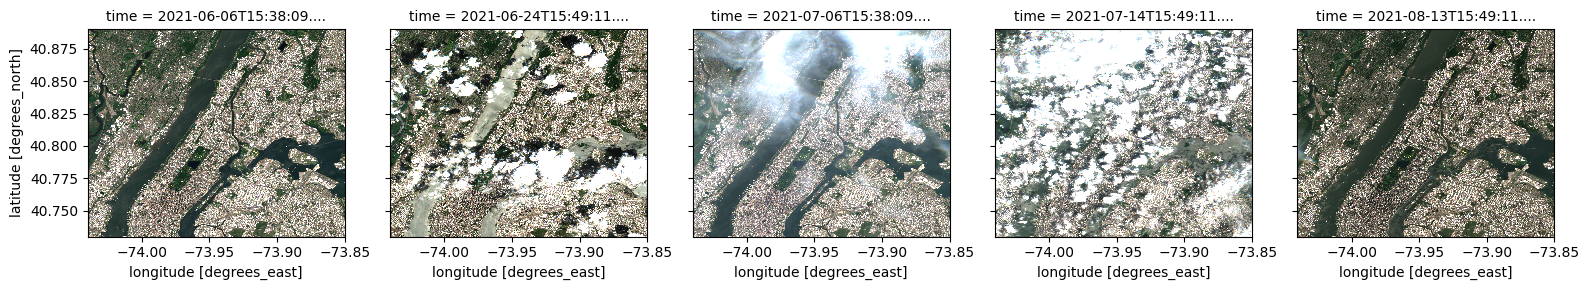

In [10]:
# Plot some images from the time series
plot_data = data[["B04","B03","B02"]].to_array()
plot_data.isel(time = [0,2,4,5,9]).plot.imshow(col='time', robust=True, vmin=0, vmax=2500)
plt.show()

### Median composite

Using normal xarray operations, we can [compute the median](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.median.html) over the time dimension. Under the assumption that clouds are not common (<30% per scene) and in random locations, the composite shouldn't contain (many) clouds, since they shouldn't be the median pixel value at that point over many images.
Since the images are heavy, this operation takes a while.

In [11]:
median = data.median(dim="time").compute()

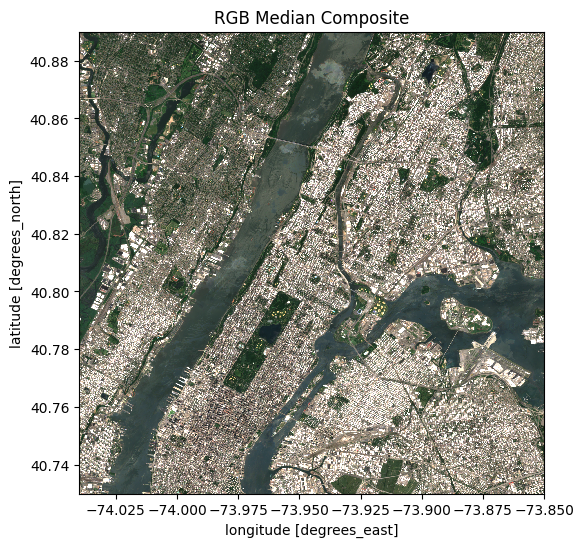

In [12]:
# Plot an RGB image for the median composite or mosaic
# Notice how this new image is void of clouds due to statistical filtering
fig, ax = plt.subplots(figsize=(6,6))
median[["B04","B03","B02"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0, vmax=2500)
ax.set_title("RGB Median Composite")
plt.show()

From the bands some indices can be computed. Here we show 3 of them

The <b>Normalized Difference Vegetation Index (NDVI)</b> is used to measure the "greenness" of vegetation and has a range of 0.0 to 1.0. Low values (0.0 to 0.25) reflect a lack of vegetation (bare soil, urban, water), middle values (0.25 to 0.6) reflect grasslands or croplands in their growing state, and high values (0.6 to 1.0) reflect dense vegetation such as trees or croplands at their peak vegetation state. Such information can be relevant to modeling urban heating as the proximity to vegetation or "green space" can mitigate urban heating. The equation uses two spectral bands where: <b>NDVI = (NIR-Red) / (NIR+Red).

In [13]:
# Calculate NDVI for the median mosaic
ndvi_median = (median.B08-median.B04)/(median.B08+median.B04)

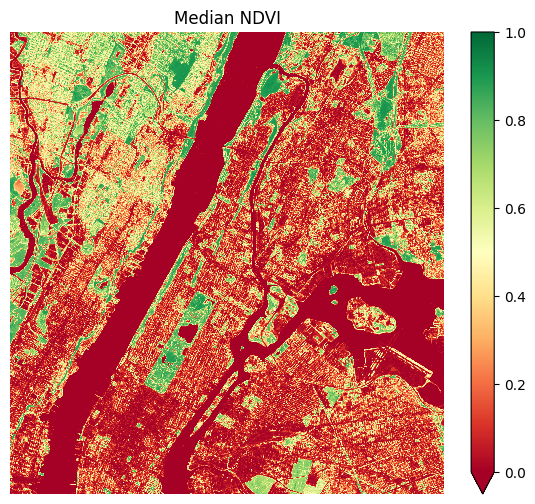

In [14]:
fig, ax = plt.subplots(figsize=(7,6))
ndvi_median.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Median NDVI")
plt.axis('off')
plt.show()

The <b>Normalized Difference Buildup Index (NDBI)</b> is a ratio-based index that uses the Near Infra-red (NIR) and shortwave-infrared (SWIR) band (1.6 um, Band-11) to highlight built-up areas or areas of urbanization. Low values (below zero) reflect a lack of urbanization and are typical of water or vegetgation. High values (above zero) reflect urbanization with the highest densities where the colors are dark red. Such information can be relevant to modeling urban heating as urban density and increase urban heating. The equation uses two spectral bands where: <b>NDBI = (SWIR-NIR) / (SWIR+NIR).

In [15]:
# Calculate NDBI for the median mosaic
ndbi_median = (median.B11-median.B08)/(median.B11+median.B08)

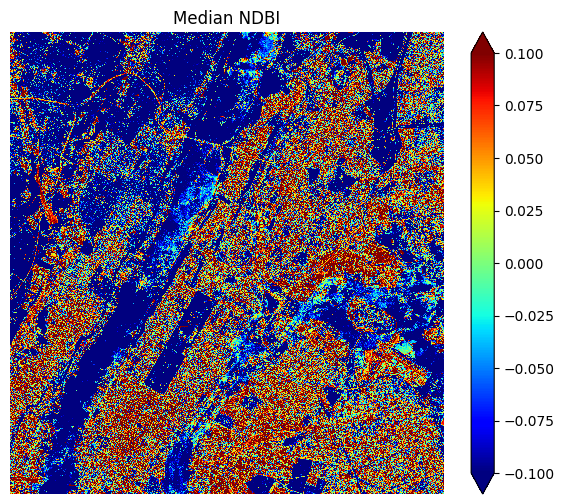

In [16]:
fig, ax = plt.subplots(figsize=(7,6))
ndbi_median.plot.imshow(vmin=-0.1, vmax=0.1, cmap="jet")
plt.title("Median NDBI")
plt.axis('off')
plt.show()

The <b>Normalized Difference Water Index (NDWI)</b> is a ratio-based index that uses the Green and Near Infra-Red (NIR) band to highlight areas with surface water. The scale below is set up to highlight areas of water (above zero) in BLUE and areas of non-water (below zero) in RED. Such information can be relevant to modeling urban heating as the proximity to water can mitigate urban heating. The equation uses two spectral bands where: <b>NDWI = (GREEN-NIR) / (GREEN+NIR).

In [17]:
# Calculate NDWI for the median mosaic
ndwi_median = (median.B03-median.B08)/(median.B03+median.B08)

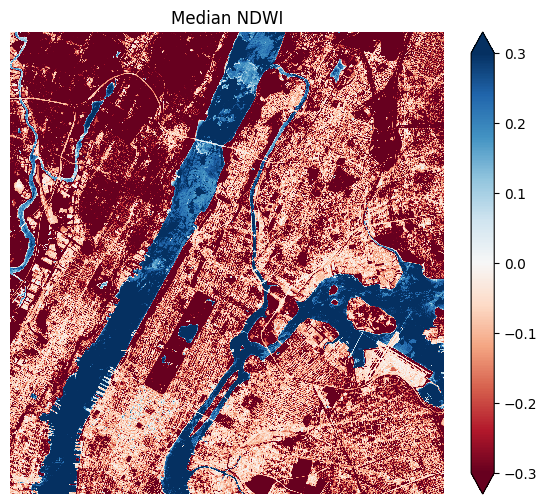

In [18]:
fig, ax = plt.subplots(figsize=(7,6))
ndwi_median.plot.imshow(vmin=-0.3, vmax=0.3, cmap="RdBu")
plt.title("Median NDWI")
plt.axis('off')
plt.show()

### Save the output data in a GeoTIFF file

In [19]:
#View the dimensions of our xarray
median

<xarray.Dataset> Size: 332MB
Dimensions:      (latitude: 1782, longitude: 2116)
Coordinates:
  * latitude     (latitude) float64 14kB 40.89 40.89 40.89 ... 40.73 40.73 40.73
  * longitude    (longitude) float64 17kB -74.04 -74.04 -74.04 ... -73.85 -73.85
    spatial_ref  int32 4B 4326
Data variables:
    B01          (latitude, longitude) float64 30MB 1.046e+03 ... 1.341e+03
    B02          (latitude, longitude) float64 30MB 887.5 887.5 ... 1.542e+03
    B03          (latitude, longitude) float64 30MB 891.5 891.5 ... 1.738e+03
    B04          (latitude, longitude) float64 30MB 909.0 909.0 ... 1.864e+03
    B05          (latitude, longitude) float64 30MB 1.166e+03 ... 2.366e+03
    B06          (latitude, longitude) float64 30MB 1.199e+03 ... 2.81e+03
    B07          (latitude, longitude) float64 30MB 1.228e+03 ... 2.894e+03
    B08          (latitude, longitude) float64 30MB 960.0 960.0 ... 2.839e+03
    B8A          (latitude, longitude) float64 30MB 1.243e+03 ... 2.952e+03
    B11          (latitude, longitude) float64 30MB 1.468e+03 ... 3.079e+03
    B12          (latitude, longitude) float64 30MB 1.458e+03 ... 2.765e+03

In [20]:
# Calculate the dimensions of the file
height = median.dims["latitude"]
width = median.dims["longitude"]

In [21]:
# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
median.rio.write_crs("epsg:4326", inplace=True)
median.rio.write_transform(transform=gt, inplace=True);

In [28]:
filename = "data/S2.tiff"
# Create the GeoTIFF output file using the defined parameters
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=11,compress='lzw',
                   predictor=3,dtype='float64') as dst:
    dst.write(median.B01,1)
    dst.write(median.B02,2)
    dst.write(median.B03,3)
    dst.write(median.B04,4)
    dst.write(median.B05,5)
    dst.write(median.B06,6)
    dst.write(median.B07,7)
    dst.write(median.B08,8)
    dst.write(median.B8A,9)
    dst.write(median.B11,10)
    dst.write(median.B12,11)
    dst.close()

## Landsat Surface Temperature

Using the `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters. The query searches for "low cloud" scenes with overall cloud cover <40%. We will also limit our search to Landsat-8 to avoid the Landsat-7 scan line corrector failure. The result is the number of scenes matching our search criteria that touch our area of interest. Some of these may be partial scenes or contain clouds.

In [39]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds, 
    datetime=time_window,
    collections=["landsat-c2-l2"],
    query={"eo:cloud_cover": {"lt": 30},"platform": {"in": ["landsat-8"]}},
)

In [57]:
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 7


Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/). We will only keep the commonly used spectral bands (Red, Green, Blue, NIR, Surface Temperature). There are also several other <b>important settings for the data</b>: We have changed the projection to epsg=4326 which is standard latitude-longitude in degrees. We have specified the spatial resolution of each pixel to be 30 meters at the equator (0.97 arc-seconds)

In [41]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [8]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
conv_factor = 111320 #meters per arc degrees at the equator
resolution = 30  # meters per pixel desired
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

### Landsat Band Summary 
The following list of bands will be loaded by the Open Data Cube (ODC) stac command:<br>
We will use two load commands to separate the RGB data from the Surface Temperature data.<br><br>
Band 2 = blue = 30m<br>
Band 3 = green = 30m<br>
Band 4 = red = 30m<br>
Band 5 = nir08 (near infrared) = 30m<br>
Band 11 = Surface Temperature = lwir11 = 100m

In [47]:
data1 = stac_load(
    items,
    bands=["red", "green", "blue", "nir08"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [48]:
data2 = stac_load(
    items,
    bands=["lwir11"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

Since the data matching our query isn't too large we can persist it in distributed memory. Once in memory, subsequent operations will be much faster.

In [62]:
# View the dimensions of our XARRAY and the loaded variables
# This insures we have the right coordinates and spectral bands in our xarray
display(data1)
display(data2)

<xarray.Dataset> Size: 24MB
Dimensions:      (latitude: 595, longitude: 706, time: 7)
Coordinates:
  * latitude     (latitude) float64 5kB 40.89 40.89 40.89 ... 40.73 40.73 40.73
  * longitude    (longitude) float64 6kB -74.04 -74.04 -74.04 ... -73.85 -73.85
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 56B 2021-06-07T15:39:15.904901 ... 202...
Data variables:
    red          (time, latitude, longitude) uint16 6MB dask.array<chunksize=(1, 595, 706), meta=np.ndarray>
    green        (time, latitude, longitude) uint16 6MB dask.array<chunksize=(1, 595, 706), meta=np.ndarray>
    blue         (time, latitude, longitude) uint16 6MB dask.array<chunksize=(1, 595, 706), meta=np.ndarray>
    nir08        (time, latitude, longitude) uint16 6MB dask.array<chunksize=(1, 595, 706), meta=np.ndarray>

<xarray.Dataset> Size: 6MB
Dimensions:      (latitude: 595, longitude: 706, time: 7)
Coordinates:
  * latitude     (latitude) float64 5kB 40.89 40.89 40.89 ... 40.73 40.73 40.73
  * longitude    (longitude) float64 6kB -74.04 -74.04 -74.04 ... -73.85 -73.85
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 56B 2021-06-07T15:39:15.904901 ... 202...
Data variables:
    lwir11       (time, latitude, longitude) uint16 6MB dask.array<chunksize=(1, 595, 706), meta=np.ndarray>

In [50]:
# Persist the data in memory for faster operations
data1 = data1.persist()
data2 = data2.persist()

### Scaling Datasets
Landsat Collection-2 Level-2 products require scaling before creating valid output products. <br>

In [51]:
# Scale Factors for the RGB and NIR bands 
scale1 = 0.0000275 
offset1 = -0.2 
data1 = data1.astype(float) * scale1 + offset1

In [52]:
# Scale Factors for the Surface Temperature band
scale2 = 0.00341802 
offset2 = 149.0 
kelvin_celsius = 273.15 # convert from Kelvin to Celsius
data2 = data2.astype(float) * scale2 + offset2 - kelvin_celsius

### View RGB (real color) images from the time series
You will notice that some of the scenes have clouds and some of the scenes have missing data due to scene boundary issues. Since Landsat is a descending orbit path across the equator, the time of acquisition for the scenes below is about 11:30am local time (note the time on the image is UTC time). Also, these images are merely for quick review and are not scaled correctly to reflect the proper Lat-Lon ratios. 

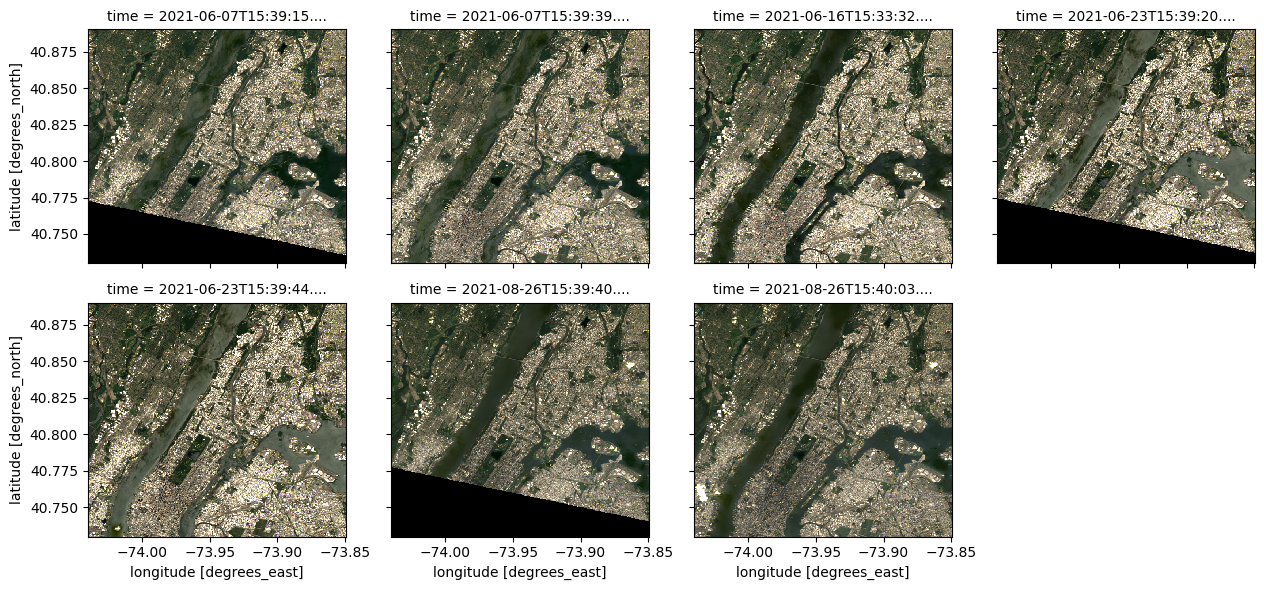

In [ ]:
plot_data = data1[["red","green","blue"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.25)
plt.show()

### Output Products

We will pick the best the best scene (no clouds, no missing data) to build our output products. This will not require any median filtering calculations as we will just pick one date from the time series.

In [70]:
# Pick one of the scenes above (numbering starts with 0)
scene = 2

### Landsat Surface Temperature

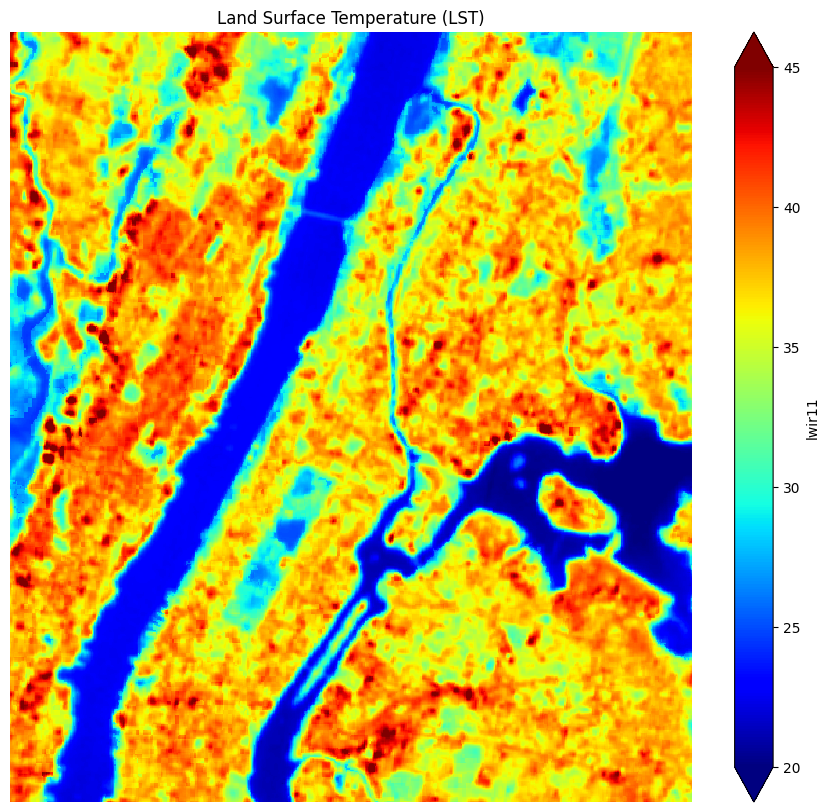

In [71]:
fig, ax = plt.subplots(figsize=(11,10))
data2.isel(time=scene).lwir11.plot.imshow(vmin=20.0, vmax=45.0, cmap="jet")
plt.title("Land Surface Temperature (LST)")
plt.axis('off')
plt.show()

### Save the output data in a GeoTIFF file

We will only save the land surface temperature, since the other bands are already present in the sentinel-2 output product with higher resolution.

In [72]:
# Only select one of the time slices to output
data3 = data2.isel(time=scene)

In [73]:
# Calculate the dimensions of the file
height = data3.dims["latitude"]
width = data3.dims["longitude"]

In [74]:
# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
data3.rio.write_crs("epsg:4326", inplace=True)
data3.rio.write_transform(transform=gt, inplace=True);

In [76]:
# Create the GeoTIFF output file using the defined parameters 
filename = "data/Landsat_LST.tiff"
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=1,compress='lzw',dtype='float64') as dst:
    dst.write(data3.lwir11,1)
    dst.close()